***Retail Bank Customers – EDA, Feature Engineering, and Segmentation***

Analyzed over 1 million customer transaction records from a retail bank to identify key customer segments and improve targeting and risk assessment. The project involved extensive exploratory data analysis, feature engineering, and K-Means clustering.

**Key Steps**:

1. Exploratory Data Analysis (EDA):

Assessed dataset structure, variable distributions, and descriptive statistics.

Evaluated and handled missing data using appropriate imputation strategies.

Detected outliers and high-cardinality categorical features.

Feature Engineering:

Created new behavioral features (recency, frequency, monetary value, balance stability, transaction patterns).

Derived time-based variables (transaction hour, month phase) and grouped location data.

Standardized and transformed features to prepare for modeling.

2. Segmentation Modeling:

Applied K-Means clustering to identify customer segments.

Determined the optimal number of clusters using both the Elbow Method and Silhouette Analysis.

Visualized clusters using PCA for dimensionality reduction.

**Outcome**:
Delivered clear segmentation insights to help the bank better distinguish client subgroups for personalized marketing and improved risk assessment.

**Dataset**:
Provided by the instructor as part of a graduate-level data analytics class. Included 1,048,556 rows with transaction and customer demographic data.


# 1. EDA and Feature Engineering

In [885]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt      #for visualization
import seaborn as sns                #for visualization
from datetime import datetime, date
import warnings
warnings.filterwarnings('ignore')


Load data_retail dataset using different arguments to avoid errors and get clean data out of a potentially messy file

In [886]:
df = pd.read_csv(
    "/Users/banhbao/Downloads/data_retail.csv",
    sep=";",                        # Based on your R code
    decimal=",",                    # Handle European-style decimals
    na_values=["", "NA", "nan", "#ARG!"],  # Treat these as missing
    encoding="utf-8",               # Or try "ISO-8859-1" if UTF-8 fails
    engine="python",                # More tolerant parser
    on_bad_lines="skip"            # Skip corrupted rows (pandas ≥ 1.3)
)

In [887]:
#Basic info
print("Dataset shape:", df.shape)       # Rows and columns
print("\nColumn names:", df.columns.tolist())  # All column names
df.head()

Dataset shape: (1048556, 9)

Column names: ['TNX_ID', 'CUST_ID', 'CUST_BIRTH_DATE', 'GENDER', 'CITY', 'BALANCE_AMT', 'TNX_DATE_DDMMYYYY', 'TNX_TIME_HHMMSS', 'TNX_AMT']


,TNX_ID,CUST_ID,CUST_BIRTH_DATE,GENDER,CITY,BALANCE_AMT,TNX_DATE_DDMMYYYY,TNX_TIME_HHMMSS,TNX_AMT
0,T1,K3635750,07.02.1953,M,DELHI,398400.28,06.01.2025,141450,26243.63
1,T2,K6647259,05.07.1974,M,UDAIPUR,11265.04,06.01.2025,131624,137.63
2,T3,K5488480,17.01.1987,F,PUNE,441485.34,23.01.2025,200211,9407.31
3,T4,K2923826,06.09.1980,M,PUNE,113206.71,08.01.2025,173743,594.20
4,T5,K7822327,07.10.1984,M,VADODARA,21431.87,18.02.2025,213701,493.74


In [888]:
print(f'Shape     : {df.shape}\n'
      f'Size      : {df.size}\n' 
      f'Dimension : {df.ndim}')

Shape     : (1048556, 9)
Size      : 9437004
Dimension : 2


In [889]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048556 entries, 0 to 1048555
Data columns (total 9 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   TNX_ID             1048556 non-null  object 
 1   CUST_ID            1048556 non-null  object 
 2   CUST_BIRTH_DATE    1045159 non-null  object 
 3   GENDER             1047456 non-null  object 
 4   CITY               1048405 non-null  object 
 5   BALANCE_AMT        1030148 non-null  float64
 6   TNX_DATE_DDMMYYYY  1048556 non-null  object 
 7   TNX_TIME_HHMMSS    1048556 non-null  int64  
 8   TNX_AMT            1044847 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


The data types of each feature were stored as character strings, including BALANCE_AMT, TNX_AMT, CUST_BIRTH_DATE, and TNX_DATE_DDMMYYYY. As a result, these variables needed to be carefully inspected and converted to their appropriate numeric or date formats before handling missing data in these columns.

In [890]:
df.describe(include=[object])  # Summary statistics for all columns

,TNX_ID,CUST_ID,CUST_BIRTH_DATE,GENDER,CITY,TNX_DATE_DDMMYYYY
count,1048556,1048556,1045159,1047456,1048405,1048556
unique,1048556,884256,17254,3,9355,88
top,T1,K5531319,1/1/1800,M,MUMBAI,06.01.2025
freq,1,6,57339,765522,103595,22102


In [891]:
df.isna().sum()

TNX_ID                   0
CUST_ID                  0
CUST_BIRTH_DATE       3397
GENDER                1100
CITY                   151
BALANCE_AMT          18408
TNX_DATE_DDMMYYYY        0
TNX_TIME_HHMMSS          0
TNX_AMT               3709
dtype: int64

In [892]:
duplicates = df[df.duplicated(subset=['CUST_ID', 'TNX_ID'], keep=False)]
print(duplicates)


Empty DataFrame
Columns: [TNX_ID, CUST_ID, CUST_BIRTH_DATE, GENDER, CITY, BALANCE_AMT, TNX_DATE_DDMMYYYY, TNX_TIME_HHMMSS, TNX_AMT]
Index: []


Check missing value:
+ No missing values were found in both TNX_ID and CUST_ID
+ All TNX_ID values were unique, confirming that each row represents a distinct transaction. 
+ The CUST_ID field contained duplicate entries, indicating that some customers made multiple transactions during the 3-month period.

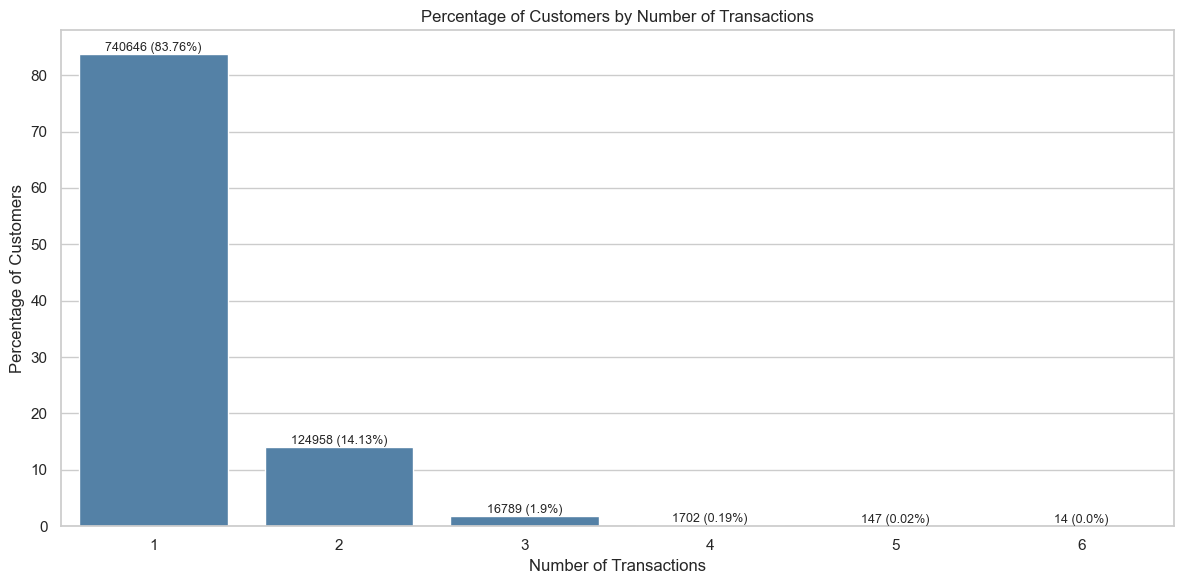

In [893]:
# Explore
# --- Customer Transaction Count Distribution ---
tx_count = df.groupby('CUST_ID').size().reset_index(name='transaction_count')

distribution = tx_count['transaction_count'].value_counts().sort_index().reset_index()
distribution.columns = ['Number of Transactions', 'Customer Count']
distribution['Percentage'] = (distribution['Customer Count'] / distribution['Customer Count'].sum()) * 100
distribution['Label'] = distribution['Customer Count'].astype(str) + " (" + distribution['Percentage'].round(2).astype(str) + "%)"

plt.figure(figsize=(12, 6))
sns.barplot(data=distribution, x='Number of Transactions', y='Percentage', color='steelblue')
for i, row in distribution.iterrows():
    plt.text(i, row['Percentage'] + 0.5, row['Label'], ha='center', fontsize=9)
plt.title("Percentage of Customers by Number of Transactions")
plt.xlabel("Number of Transactions")
plt.ylabel("Percentage of Customers")
plt.tight_layout()
plt.show()


TRANSACTION FREQUENCY INSIGHTS (3-month period):
- 83.76%: Only 1 transaction (low-engagement majority)
- 14.13%: 2 transactions
- <2%: 3+ transactions (sharp decline)
- Only 14 customers made 6 transactions (extreme outliers)

SEGMENTATION IMPLICATIONS:
 1. Clear distinction between:
  - One-time users (dominant group)
  - Repeat transactors (small but valuable)
 2. Model should account for extreme skewness in transaction behavior


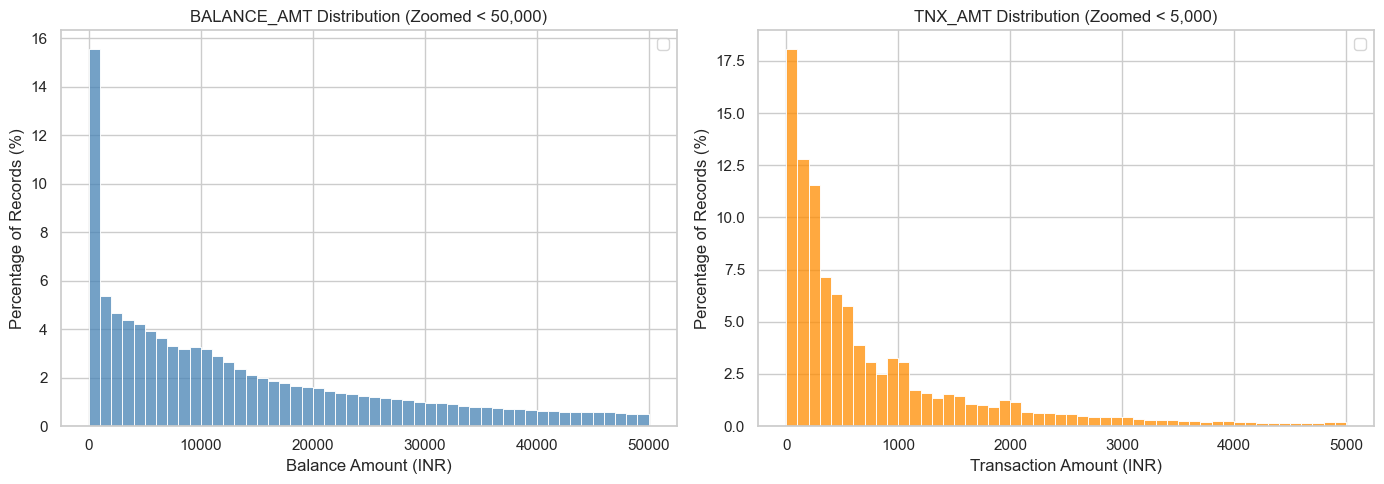

In [894]:
# --------- Distribution of BALANCE_AMT and TNX_AMT ---------
plt.figure(figsize=(14, 5))

# Zooom In: BALANCE_AMT under 50,000
plt.subplot(1, 2, 1)
balance_filtered = df['BALANCE_AMT'].dropna()
balance_zoomed = balance_filtered[balance_filtered < 50000]
sns.histplot(balance_zoomed, bins=50, stat='percent', color='steelblue')
plt.title("BALANCE_AMT Distribution (Zoomed < 50,000)")
plt.xlabel("Balance Amount (INR)")
plt.ylabel("Percentage of Records (%)")
plt.legend()

# Zoom In: TNX_AMT under 5,000
plt.subplot(1, 2, 2)
tnx_filtered = df['TNX_AMT'].dropna()
tnx_zoomed = tnx_filtered[tnx_filtered < 5000]
sns.histplot(tnx_zoomed, bins=50, stat='percent', color='darkorange')
plt.title("TNX_AMT Distribution (Zoomed < 5,000)")
plt.xlabel("Transaction Amount (INR)")
plt.ylabel("Percentage of Records (%)")
plt.legend()

plt.tight_layout()
plt.show()

BALANCE & TRANSACTION AMOUNTS:

This visualization focuses on **zoomed-in ranges** of transaction and balance amounts (<50,000 INR for balance amount and <5000 INR for each transaction amount) to better highlight the distribution of most records without distortion from extreme outliers.  
By limiting the x-axis, we can clearly see the density and spread of typical customer behaviors while still keeping the summary statistics (mean and median) visible for context.

From the chart, we can see:
- Highly right-skewed distributions
- 15.5%: Near-zero balances
- 18%: Very low-value transactions

Over 15.5% of customers have near-zero balances, and almost 18% of transactions are of very low value, suggesting that a significant portion of the customer base consists of low-activity or low-value accounts.

The distributions of both BALANCE_AMT and TNX_AMT are highly right-skewed, this suggests that the majority of customers holding low balances and making small transactions.

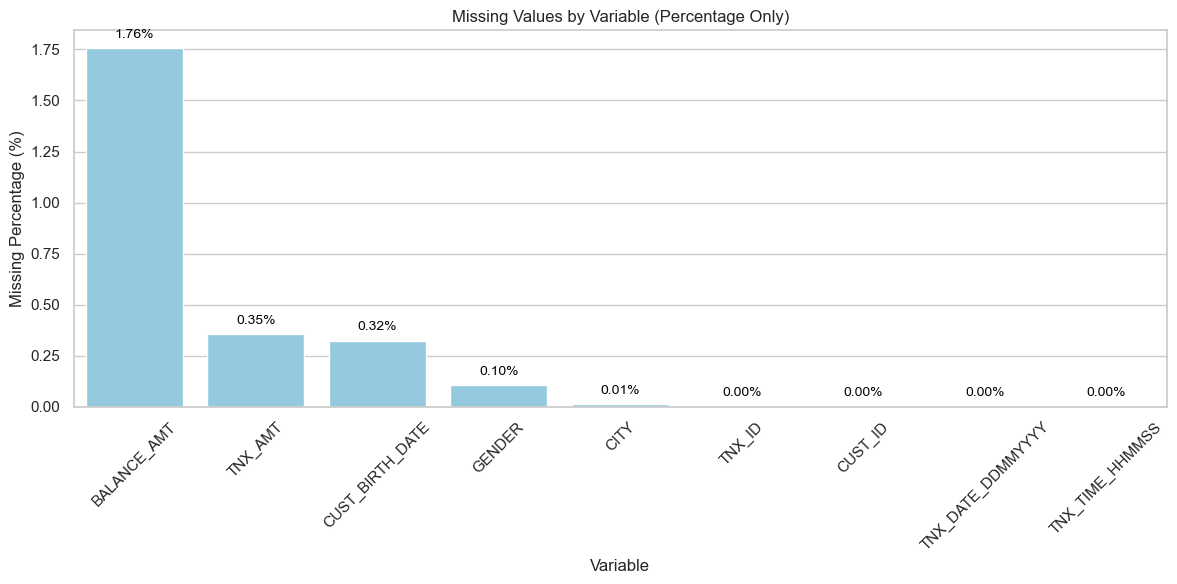

In [895]:
# Alternative to compute missing from dataset
missing_df = df.isna().sum().reset_index()
missing_df.columns = ['Variable', 'Missing Count']
missing_df['Missing (%)'] = (missing_df['Missing Count'] / len(df)) * 100
missing_df = missing_df.sort_values(by='Missing (%)', ascending=False)

total_rows = 1048556

missing_df['Missing (%)'] = (missing_df['Missing Count'] / total_rows) * 100
missing_df = missing_df.sort_values(by='Missing (%)', ascending=False)

# Plot with only percentage labels
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Variable', y='Missing (%)', data=missing_df, color='skyblue')

# Add percentage labels
for bar, pct in zip(ax.patches, missing_df['Missing (%)']):
    label = f"{pct:.2f}%"
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.05,
        label,
        ha='center',
        fontsize=10,
        color='black'
    )

plt.title("Missing Values by Variable (Percentage Only)")
plt.ylabel("Missing Percentage (%)")
plt.xlabel("Variable")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

A barchart summarizing missing values shows:

Among the variables with missing data, BALANCE_AMT has the highest proportion at 1.76%, followed by TNX_AMT (0.35%), CUST_BIRTH_DATE (0.32%), GENDER (0.1%), and CITY (0.01%). 
Overall, the dataset has a relatively low level of missingness, with only a few variables requiring imputation or further handling.

To build an effective customer segmentation model, a set of demographic and behavioral features was selected based on their relevance to customer profiling. Demographic variables include CUST_ID, AGE, GENDER, and CITY, which help capture customer identity and location-based differences.

To ensure data quality before segmentation modeling, missing values were addressed based on the nature and role of each variable

In [896]:
#Step 1: Handle CUST_BIRTH_DATE
# Convert CUST_BIRTH_DATE to datetime format
df['CUST_BIRTH_DATE'] = pd.to_datetime(
    df['CUST_BIRTH_DATE'],
    format='%d.%m.%Y',
    errors='coerce'
)

# Calculate AGE
today = pd.to_datetime("today")
df['AGE'] = ((today - df['CUST_BIRTH_DATE']).dt.days / 365.25)

# Impute
df['AGE'] = df['AGE'].fillna(df['AGE'].median()).astype(int)

print(df[['CUST_BIRTH_DATE', 'AGE']].head())

  CUST_BIRTH_DATE  AGE
0      1953-02-07   72
1      1974-07-05   50
2      1987-01-17   38
3      1980-09-06   44
4      1984-10-07   40


CUST_BIRTH_DATE variable was converted into AGE, and missing ages were imputed using the median to preserve central demographic characteristics.

In [897]:
#GENDER and CITY
print(df['GENDER'].unique())
print(df['CITY'].unique())

['M' 'F' nan 'T']
['DELHI' 'UDAIPUR' 'PUNE' ... 'SHYAMDHAM TEMPLE SURAT' 'KHAMAM'
 'KALYANI MOTORS BANGALORE']


In [898]:
# Handle missing values for GENDER and CITY
df['GENDER'] = df['GENDER'].fillna('Unknown')
df['GENDER'] = df['GENDER'].replace('T', 'Unknown')
df['CITY'] = df['CITY'].fillna('Unknown')

# Additionally, create indicator flags for missing values
df['GENDER_MISSING'] = (df['GENDER'] == 'Unknown').astype(int)
df['CITY_MISSING'] = (df['CITY'] == 'Unknown').astype(int)

# Verify the changes
print("Gender value counts after imputation:")
print(df['GENDER'].value_counts(dropna=False))

print("\nCity value counts after imputation:")
print(f"Unique cities: {df['CITY'].nunique()}")
print(f"Top 10 cities:\n{df['CITY'].value_counts().head(10)}")


Gender value counts after imputation:
GENDER
M          765522
F          281933
Unknown      1101
Name: count, dtype: int64

City value counts after imputation:
Unique cities: 9356
Top 10 cities:
CITY
MUMBAI       103595
NEW DELHI     84926
BANGALORE     81553
GURGAON       73818
DELHI         71019
NOIDA         32783
CHENNAI       30009
PUNE          25851
HYDERABAD     23049
THANE         21505
Name: count, dtype: int64


GENDER was imputed as "Unknown" to retain customers with unspecified gender, while missing entries in CITY were labeled as "Unknown" to represent unspecified or uncommon locations. This approach ensured that all customers could be included in the segmentation process without introducing bias or distortion from missing
data.

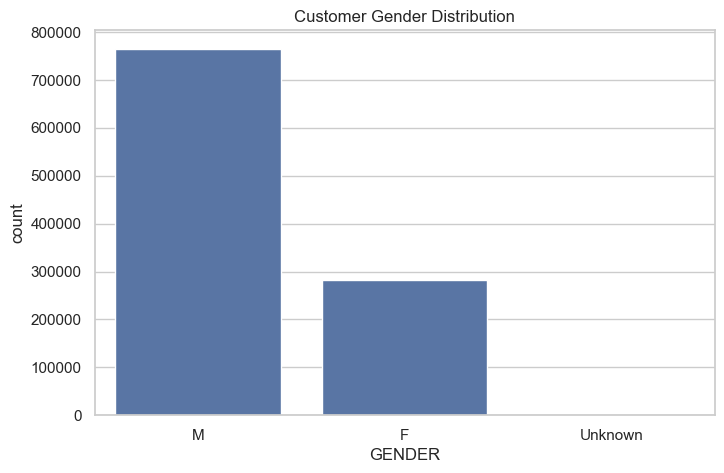

In [899]:
#Gender Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='GENDER', order=['M', 'F', 'Unknown'])
plt.title('Customer Gender Distribution')
plt.show()

The majority of customers are male (M), representing most of the dataset. Female (F) customers account for a smaller proportion, while “T” and “Unknown” genders are very rare. This imbalance suggests that gender may play a role in segmentation, but the “T” and “Unknown” categories are too small to draw strong conclusions without further investigation.

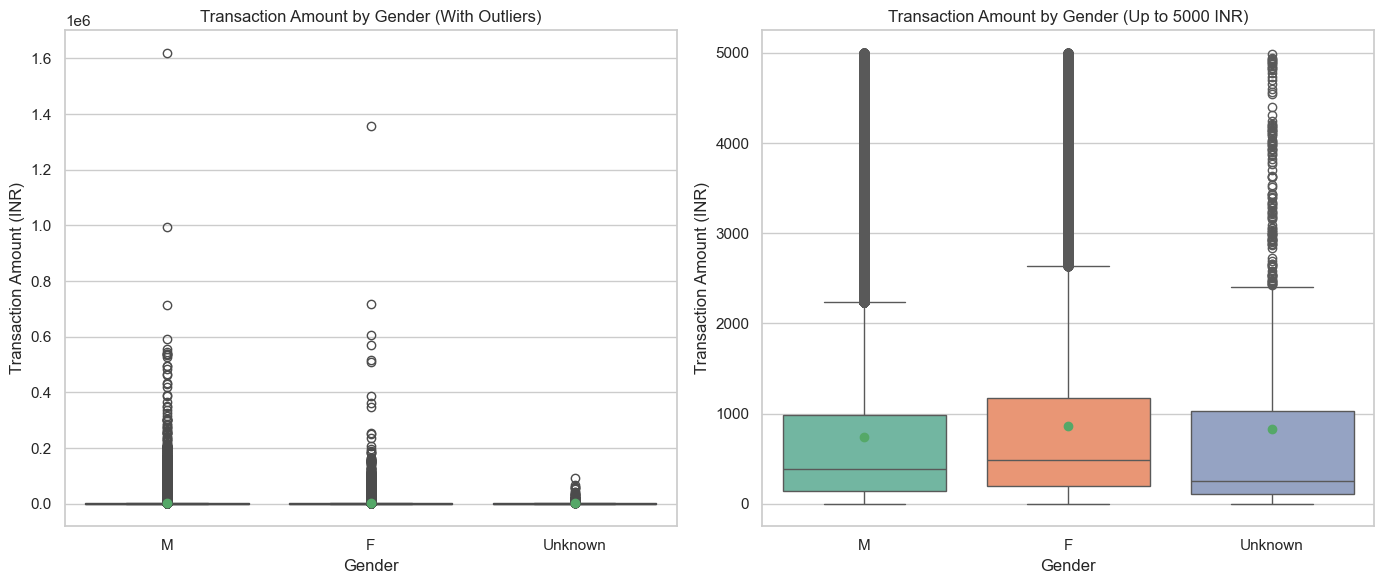

In [900]:
# Prepare data
gender_df = df[['GENDER', 'TNX_AMT']].dropna()

# Create boxplots
plt.figure(figsize=(14, 6))

# Boxplot 1: Full TNX_AMT distribution
plt.subplot(1, 2, 1)
sns.boxplot(
    data=gender_df,
    x='GENDER',
    y='TNX_AMT',
    showmeans=True,
    meanprops={"marker": "o", "color": "red"}
)
plt.title("Transaction Amount by Gender (With Outliers)")
plt.xlabel("Gender")
plt.ylabel("Transaction Amount (INR)")

# Boxplot 2: TNX_AMT ≤ 5000 INR
plt.subplot(1, 2, 2)
sns.boxplot(
    data=gender_df[gender_df['TNX_AMT'] <= 5000],
    x='GENDER',
    y='TNX_AMT',
    hue='GENDER',
    palette='Set2',
    showmeans=True,
    meanprops={"marker": "o", "color": "red"},
    dodge=False
)
plt.legend([],[], frameon=False)
plt.title("Transaction Amount by Gender (Up to 5000 INR)")
plt.xlabel("Gender")
plt.ylabel("Transaction Amount (INR)")

plt.tight_layout()
plt.show()


A boxplot comparing transaction amounts by gender (zoomed to exclude extreme outliers) shows that female customers tend to have slightly higher median transaction amounts and greater variability in spending. Both genders include high-value transactions, but most activity falls below 5,000 PLN

This suggests that their transaction behaviors differ in a meaningful way. This insight supports the inclusion of GENDER as a potentially valuable feature in segmentation modeling, as it may help differentiate customer groups based on spending behavior.

In [901]:
# Convert and impute balances/amounts
df["BALANCE_AMT"] = df["BALANCE_AMT"].replace(",", "", regex=True).astype(float).fillna(0)
df["TNX_AMT"] = df["TNX_AMT"].replace(",", "", regex=True).astype(float).fillna(0)
# Process TNX_DATE
# Convert TNX_DATE_DDMMYYYY early
df["TNX_DATE_DDMMYYYY"] = pd.to_datetime(
    df["TNX_DATE_DDMMYYYY"],
    format="%d.%m.%Y",   # Adjust format if needed
    errors="coerce"
)

reference_date = pd.to_datetime("today")
df["TNX_DATE_DDMMYYYY"] = df["TNX_DATE_DDMMYYYY"].fillna(reference_date)

# Process TNX_HOUR
df["TNX_TIME_HHMMSS"] = df["TNX_TIME_HHMMSS"].astype(str).str.zfill(6)
df["TNX_HOUR"] = df["TNX_TIME_HHMMSS"].str[0:2].astype(int)


In [902]:
# Customer-level aggregations
customer_features = df.groupby("CUST_ID").agg(
    GENDER=("GENDER", "first"),
    CITY=("CITY", "first"),
    AGE=("AGE", "first"),
    TOTAL_TNX=("TNX_ID", "count"),
    TOTAL_TNX_AMT=("TNX_AMT", "sum"),
    AVG_TNX_AMT=("TNX_AMT", "mean"),
    MAX_BALANCE=("BALANCE_AMT", "max"),
    MIN_BALANCE=("BALANCE_AMT", "min"),
    LAST_TNX_DATE=("TNX_DATE_DDMMYYYY", "max"),
    TNX_HOUR=("TNX_HOUR", "median"),  # Median hour per customer 
).reset_index()

In [903]:
# Fill LAST_TNX_DATE missing with today
reference_date = pd.to_datetime("today")
customer_features["LAST_TNX_DATE"] = customer_features["LAST_TNX_DATE"].fillna(reference_date)

# BALANCE_RANGE
customer_features["BALANCE_RANGE"] = customer_features["MAX_BALANCE"] - customer_features["MIN_BALANCE"]

# RECENCY_DAYS
customer_features["RECENCY_DAYS"] = (reference_date - customer_features["LAST_TNX_DATE"]).dt.days
customer_features["RECENCY_DAYS"] = customer_features["RECENCY_DAYS"].fillna(0).astype(int)

# LAST_TNX_DATE components
customer_features["LAST_TNX_DATE_MM"] = customer_features["LAST_TNX_DATE"].dt.month
customer_features["LAST_TNX_DATE_DD"] = customer_features["LAST_TNX_DATE"].dt.day

# TXN_MONTH_PHASE
def get_month_phase(day):
    if 1 <= day <= 10:
        return "Early"
    elif 11 <= day <= 20:
        return "Mid"
    elif 21 <= day <= 31:
        return "Late"
    else:
        return "Unknown"

customer_features["TXN_MONTH_PHASE"] = customer_features["LAST_TNX_DATE_DD"].apply(get_month_phase)



In [904]:
# Reorder columns
final_columns = [
    "CUST_ID", "AGE", "GENDER", "CITY",
    "TOTAL_TNX", "TOTAL_TNX_AMT", "AVG_TNX_AMT",
    "MAX_BALANCE", "MIN_BALANCE", "BALANCE_RANGE",
    "RECENCY_DAYS", "TNX_HOUR",
    "LAST_TNX_DATE_MM", "LAST_TNX_DATE_DD", "TXN_MONTH_PHASE"
]

final_dataset = customer_features[final_columns]

In [905]:
# Final check
print("✅ Final dataset shape:", final_dataset.shape)
print("✅ Final columns:", final_dataset.columns.tolist())

✅ Final dataset shape: (884256, 15)
✅ Final columns: ['CUST_ID', 'AGE', 'GENDER', 'CITY', 'TOTAL_TNX', 'TOTAL_TNX_AMT', 'AVG_TNX_AMT', 'MAX_BALANCE', 'MIN_BALANCE', 'BALANCE_RANGE', 'RECENCY_DAYS', 'TNX_HOUR', 'LAST_TNX_DATE_MM', 'LAST_TNX_DATE_DD', 'TXN_MONTH_PHASE']


In [906]:
df = final_dataset.copy()


In [907]:
print(df.shape)       # Rows and columns
print("\nColumn names:", df.columns.tolist())  # All column names
print(df.head())

(884256, 15)

Column names: ['CUST_ID', 'AGE', 'GENDER', 'CITY', 'TOTAL_TNX', 'TOTAL_TNX_AMT', 'AVG_TNX_AMT', 'MAX_BALANCE', 'MIN_BALANCE', 'BALANCE_RANGE', 'RECENCY_DAYS', 'TNX_HOUR', 'LAST_TNX_DATE_MM', 'LAST_TNX_DATE_DD', 'TXN_MONTH_PHASE']
    CUST_ID  AGE GENDER       CITY  TOTAL_TNX  TOTAL_TNX_AMT  AVG_TNX_AMT  \
0  K1010011   32      F      NOIDA          2        4958.82     2479.410   
1  K1010012   30      M     MUMBAI          1        1483.14     1483.140   
2  K1010014   40      M     MUMBAI          2        1513.77      756.885   
3  K1010018   35      F  CHAMPARAN          1          31.41       31.410   
4  K1010024   60      M    KOLKATA          1        5230.62     5230.620   

   MAX_BALANCE  MIN_BALANCE  BALANCE_RANGE  RECENCY_DAYS  TNX_HOUR  \
0    121414.05     33988.75       87425.30           126       6.5   
1     24763.09     24763.09           0.00           156      20.0   
2    164956.21     36523.89      128432.32           161      18.5   
3       499.5

Behavioral variables (BALANCE_AMT and TNX_AMT): missing values were imputed with 0, reflecting either inactivity or the absence of balance or transaction data. 

Behavioral features were engineered from transaction and balance data to reflect customer
activity and value. 

To capture transaction frequency and monetary value: 
 TOTAL_TNX: Number of transactions
 TOTAL_TNX_AMT: Total Transaction amount
 AVG_TNX_AMT: Average transaction amount
 
To to reflect financial capacity and balance volatility, we calculated monetary value:
 MAX_BALANCE: Maximum observed account balance
 MIN_BALANCE: Minimum observed account balance
 BALANCE_RANGE: Difference between max and min balance

To quantify how recently the customer was active
RECENCY_DAYS: Days since last transaction

To capture time-of-day and calendar-based behavior patterns:
LAST_TNX_DATE_MM: Month of last transaction (1-12)
LAST_TNX_DATE_DD: Day of month of last transaction (1-31)
TNX_MONTH_PHASE: Part of the month: Early / Mid / Late
They were extracted from timestamp fields 

Convert the variables to datetime and impute the missing values with 0

Together, these variables in the final_features dataset provide a balanced view of customer
characteristics and behaviors, allowing for data pre-processing preparation for the
segmentation model-building process.

In [908]:
missing_summary = df.isnull().sum()

# Show only columns with missing values
missing_summary = missing_summary[missing_summary > 0]

# Display the result
print("🔎 Columns with missing values:")
print(missing_summary)

🔎 Columns with missing values:
Series([], dtype: int64)


The new dataset final_features created contains over 884256 observations of customer transactions, including:
AGE, GENDER, CITY
TOTAL_TNX, TOTAL_TNX_AMT, AVG_TNX_AMT
MAX_BALANCE, MIN_BALANCE, BALANCE_RANGE, RECENCY_DAYS
TXN_MONTH_PHASE

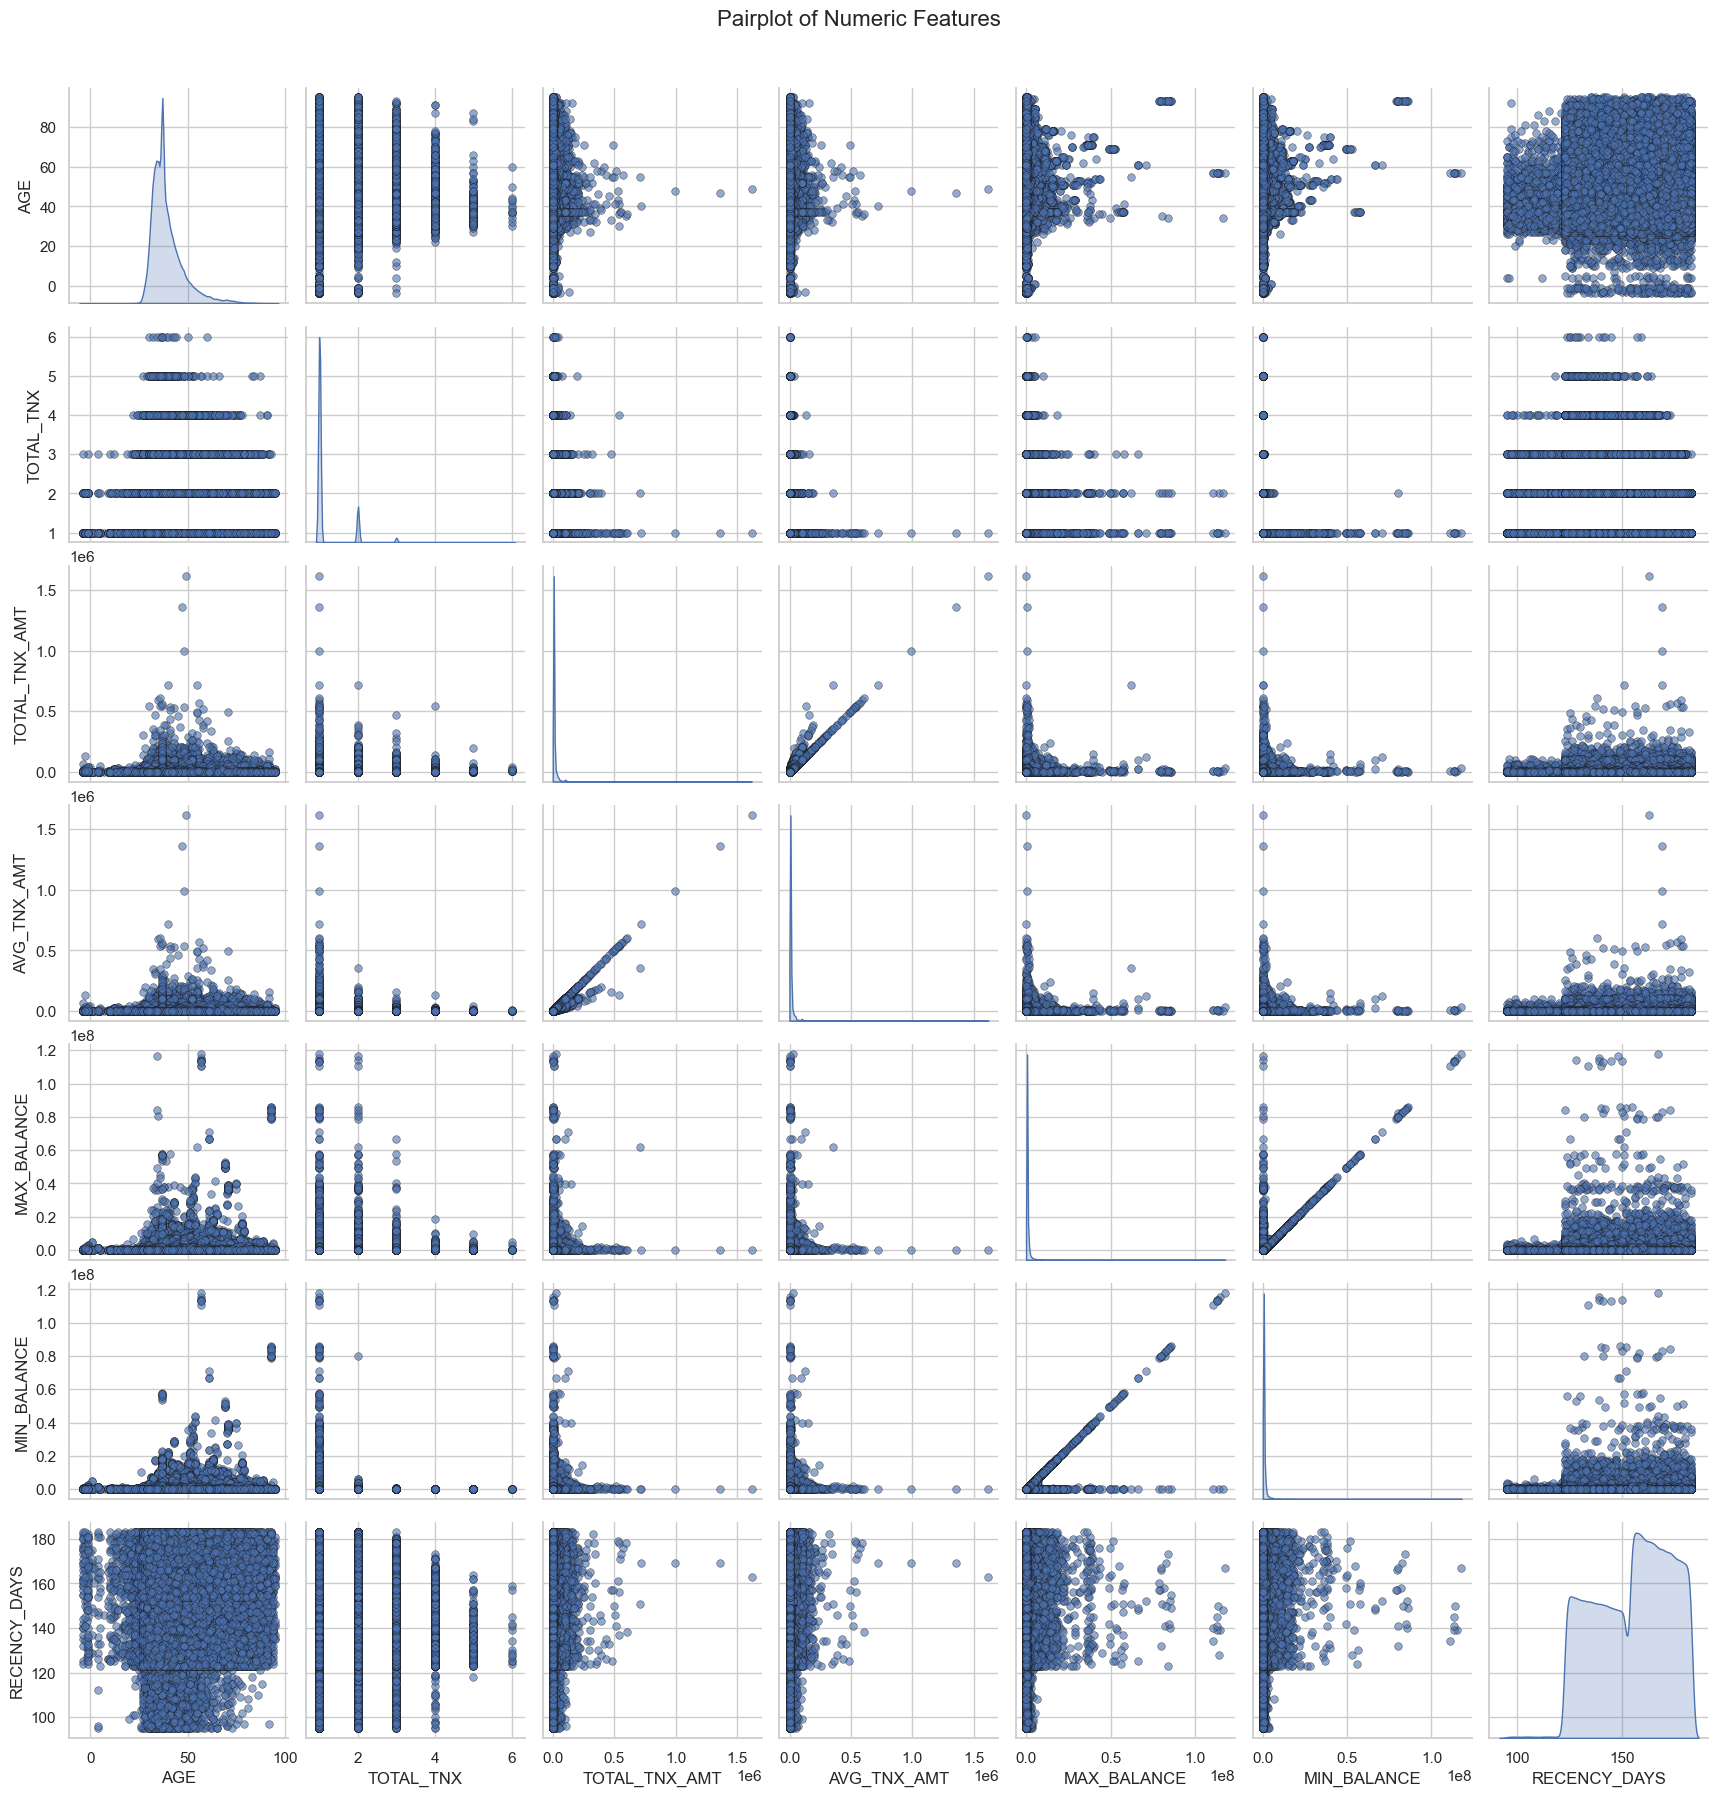

In [909]:
numeric_cols = [
    'AGE',
    'TOTAL_TNX',
    'TOTAL_TNX_AMT',
    'AVG_TNX_AMT',
    'MAX_BALANCE',
    'MIN_BALANCE',
    'RECENCY_DAYS'
]
sns.set(style="whitegrid", context="notebook")

pairplot = sns.pairplot(
    df[numeric_cols],
    diag_kind="kde",
    plot_kws={"alpha": 0.6, "s": 30, "edgecolor": "k"},
    height=2.5
)

pairplot.fig.suptitle(
    "Pairplot of Numeric Features",
    fontsize=16,
    y=1.03
)
plt.show()


The pairplot shows that most numeric variables are highly skewed, especially transaction and balance amounts. There is a very strong positive correlation between MAX_BALANCE and MIN_BALANCE, as expected (customers with higher maximum balances also tend to have higher minimum balances). 

TOTAL_TNX_AMT and AVG_TNX_AMT are also strongly correlated. No clear relationships are visible between AGE and transaction variables. 

Overall, the variables capture different aspects of customer behavior with some redundancy between transaction amount metrics.


# 2. Customer Segmentation - K-Means methods
1. *Better Feature Engineering*
2. *Categorical Variable Handling*
3. *Outlier Removal*
4. *Feature Scaling*
5. *Cluster Validation*

Goal: Building the segmentation model
Using the selected variables (make relevant transformations if necessary), build a segmentation
model using the K-means method. Briefly justify the choice of the optimal number of clusters
(using at least 2 different methods), as well as the choice of optimal cluster initialization points.
Based on your EDA so far, the best variables for K-Means clustering are:

AGE (demographic)

TOTAL_TNX (activity)

TOTAL_TNX_AMT (volume)

AVG_TNX_AMT (behavior)

MAX_BALANCE (wealth)

RECENCY_DAYS (recency of engagement)

In [910]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.utils import resample


In [948]:
df = final_dataset.copy()

In [949]:
missing_summary = df.isnull().sum()

# Show only columns with missing values
missing_summary = missing_summary[missing_summary > 0]

# Display the result
print("🔎 Columns with missing values:")
print(missing_summary)


🔎 Columns with missing values:
Series([], dtype: int64)


In [950]:
print(df.shape)       # Rows and columns
print("\nColumn names:", df.columns.tolist())  # All column names
df.head()

(884256, 15)

Column names: ['CUST_ID', 'AGE', 'GENDER', 'CITY', 'TOTAL_TNX', 'TOTAL_TNX_AMT', 'AVG_TNX_AMT', 'MAX_BALANCE', 'MIN_BALANCE', 'BALANCE_RANGE', 'RECENCY_DAYS', 'TNX_HOUR', 'LAST_TNX_DATE_MM', 'LAST_TNX_DATE_DD', 'TXN_MONTH_PHASE']


,CUST_ID,AGE,GENDER,CITY,TOTAL_TNX,TOTAL_TNX_AMT,AVG_TNX_AMT,MAX_BALANCE,MIN_BALANCE,BALANCE_RANGE,RECENCY_DAYS,TNX_HOUR,LAST_TNX_DATE_MM,LAST_TNX_DATE_DD,TXN_MONTH_PHASE
0,K1010011,32,F,NOIDA,2,4958.82,2479.410,121414.05,33988.75,87425.30,126,6.5,2,27,Late
1,K1010012,30,M,MUMBAI,1,1483.14,1483.140,24763.09,24763.09,0.00,156,20.0,1,28,Late
2,K1010014,40,M,MUMBAI,2,1513.77,756.885,164956.21,36523.89,128432.32,161,18.5,1,23,Late
3,K1010018,35,F,CHAMPARAN,1,31.41,31.410,499.55,499.55,0.00,134,17.0,2,19,Mid
4,K1010024,60,M,KOLKATA,1,5230.62,5230.620,83693.76,83693.76,0.00,165,14.0,1,19,Mid


In [952]:
# Create meaningful features
# Bin MAX_BALANCE into categorical ranges
df['BALANCE_RANGE'] = pd.cut(
    df['MAX_BALANCE'],
    bins=[0, 1000, 5000, 10000, np.inf],
    labels=['Low', 'Medium', 'High', 'Very High']
)
# Transaction frequency (transactions per day)
df['TNX_FREQUENCY'] = df['TOTAL_TNX'] / (df['RECENCY_DAYS'] + 1e-6)  # Avoid division by zero

# Balance stability
df['BALANCE_STABILITY'] = df['MAX_BALANCE'] - df['MIN_BALANCE']

# Time of day (example: categorize TNX_HOUR)
df['TIME_OF_DAY'] = pd.cut(
    df['TNX_HOUR'],
    bins=[0, 12, 18, 24],
    labels=['Morning', 'Afternoon', 'Evening'],
    right=False
)

# Keep top 20 cities, group others
top_cities = df['CITY'].value_counts().nlargest(20).index
df['CITY_GROUPED'] = df['CITY'].where(df['CITY'].isin(top_cities), 'Other')



In [953]:
# Select features
features = df[[
    'AGE',
    'TNX_FREQUENCY',
    'AVG_TNX_AMT',
    'MAX_BALANCE',
    'BALANCE_STABILITY',
    'GENDER',
    'CITY_GROUPED',
    'BALANCE_RANGE',
    'TIME_OF_DAY'
]]

# One-hot encode categoricals
features = pd.get_dummies(
    features,
    columns=['GENDER', 'CITY_GROUPED', 'BALANCE_RANGE', 'TIME_OF_DAY'],
    drop_first=True
)

In [954]:
from sklearn.ensemble import IsolationForest

# Detect outliers
scaler = StandardScaler()
scaled_temp = scaler.fit_transform(features)
clf = IsolationForest(contamination=0.01)  # Remove top 1% outliers
outliers = clf.fit_predict(scaled_temp)

# Filter data
df_clean = df[outliers == 1]
features_clean = features[outliers == 1]

In [955]:
from sklearn.preprocessing import StandardScaler

# Identify numerical columns (excluding encoded binaries)
numerical_cols = ['AGE', 'TNX_FREQUENCY', 'AVG_TNX_AMT', 'MAX_BALANCE', 'BALANCE_STABILITY']

# Scale
scaler = StandardScaler()
features_clean = features_clean.copy()
features_clean[numerical_cols] = scaler.fit_transform(features_clean[numerical_cols])

**Binning MAX_BALANCE into Ranges (optional exploratory step)**
To better understand the distribution of customer balances and identify potential tiers of financial capacity. Binning can reveal patterns not visible in continuous variables and supports grouping of extreme outliers.

**Creating TNX_FREQUENCY (Total Transactions per Active Day)**
Captures the intensity of customer engagement by measuring how frequently they transact when active. This helps differentiate casual users from highly active ones, which is valuable for segmentation.

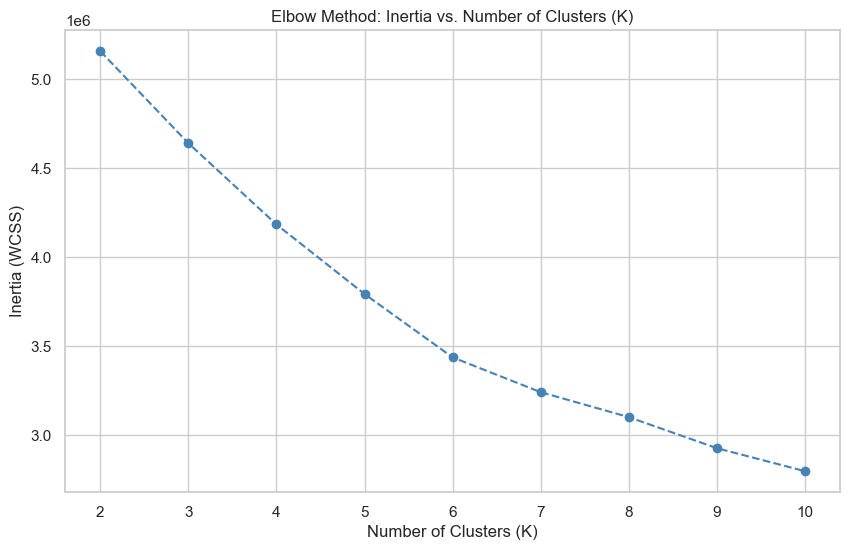

In [956]:
#Optimal Number of Clusters K
#Elbow Method
k_values = list(range(2, 11))
inertias = []
dbi_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(features_clean)
    inertias.append(kmeans.inertia_)
    dbi_scores.append(davies_bouldin_score(features_clean, labels))

# Plot Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, marker='o', linestyle='--', color='steelblue')
plt.title("Elbow Method: Inertia vs. Number of Clusters (K)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (WCSS)")
plt.xticks(k_values)
plt.grid(True)
plt.show()

The Elbow Method is one of the most commonly used techniques to find the optimal number of clusters in K-Means. This Method is computationally efficient and well-suited for large datasets, making it ideal for analyzing over 880,000 retail bank customer records.

Observations:
- From K=2 to K=4, inertia decreases steeply, indicating real improvements.After K=4–5, improvements become marginal (flatter curve).. This inflection point suggests that adding more clusters beyond this point yields diminishing returns in terms of internal compactness.

Thus, K = 4 is a practical and interpretable choice, balancing model complexity and cluster quality.


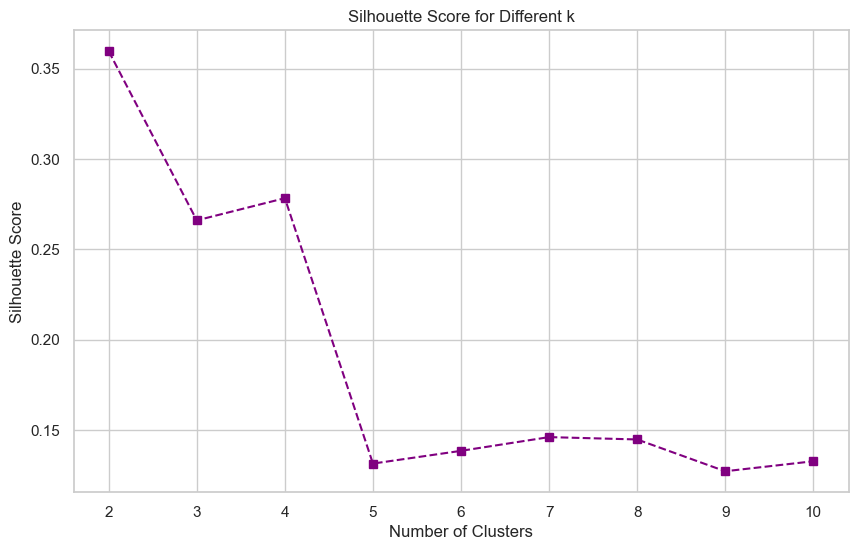

In [957]:
#silhouette Score Method

from sklearn.utils import resample

sampled_features = resample(features_clean, n_samples=3000, random_state=42)

silhouette_scores = []

k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=5)
    labels = kmeans.fit_predict(sampled_features)
    score = silhouette_score(sampled_features, labels)
    silhouette_scores.append(score)


# Plot silhouette scores
plt.figure(figsize=(10,6))
plt.plot(k_range, silhouette_scores, marker='s', linestyle='--', color='purple')
plt.title('Silhouette Score for Different k')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()

The Silhouette Score measures how well-separated and cohesive the clusters are. A higher score indicates better-defined and well-separated clusters

Due to the computational cost of calculating Silhouette Scores on large datasets (with complexity approximately O(n²)), we applied sampling (n_samples = 3000) and ran the loop with a fixed random_state = 42 to ensure reproducibility and efficiency.

Observations:

- The score drops sharply after K=4 and remains low and flat from K=5 onward.

- K=2 shows the highest Silhouette (~0.36), but fewer clusters may oversimplify.

- K=4 still retains a relatively good score (~0.28) compared to higher K values.

K=4 offers a reasonable trade-off: more granular segments with acceptable cohesion. Using K>4 does not improve cluster quality (silhouette ~0.13–0.15).

In [958]:
# Assign clusters
kmeans_final = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
df_clean = df_clean.copy()
df_clean['Cluster'] = kmeans_final.fit_predict(features_clean)


**Conclusion**:

Both methods consistently point to K = 4 as the most appropriate number of clusters for this segmentation task. This value offers a strong balance between internal cohesion (via Elbow) and external separation (via Silhouette), while remaining interpretable and scalable for operational use.

In [959]:
# Helper function to find mode
def most_common(x):
    return x.mode().iloc[0] if not x.mode().empty else np.nan

# Count records per cluster
cluster_counts = df_clean['Cluster'].value_counts().sort_index().reset_index()
cluster_counts.columns = ['Cluster', 'count']

# Profile each cluster
cluster_profile = df_clean.groupby('Cluster').agg({
    'AGE': 'mean',
    'MAX_BALANCE': 'mean',
    'BALANCE_STABILITY': 'mean',
    'GENDER': most_common,
    'CITY': most_common
}).rename(columns={
    'AGE': 'avg_age',
    'MAX_BALANCE': 'avg_max_balance',
    'BALANCE_STABILITY': 'avg_balance_stability',
    'GENDER': 'common_gender',
    'CITY': 'common_city'
}).reset_index()

# Merge count
cluster_profile = cluster_counts.merge(cluster_profile, on='Cluster')

# Display result
print(cluster_profile)

   Cluster   count    avg_age  avg_max_balance  avg_balance_stability  \
0        0  139623  53.629137     2.532556e+05            1894.274767   
1        1  604881  36.224626     6.320933e+04               3.184766   
2        2   11109  41.103520     1.217830e+06          574481.234462   
3        3  119800  37.970217     7.175602e+04           57608.796812   

  common_gender common_city  
0             M      MUMBAI  
1             M      MUMBAI  
2             M      MUMBAI  
3             M      MUMBAI  


Using the selected value K = 4, we implemented the final K-means clustering model, which segmented the customer  dataset into four distinct groups.

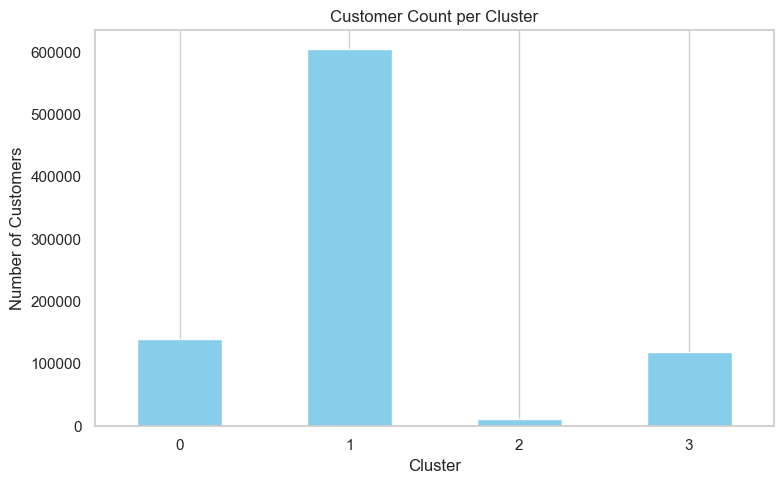

In [961]:
# Visualization: Plotting the number of customers in each cluster
# Count number of customers in each cluster
cluster_counts = df_clean['Cluster'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(8, 5))
cluster_counts.plot(kind='bar', color='skyblue')
plt.title("Customer Count per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

This bar chart provides a clear overview of the size of each customer segment, highlighting
the dominance of the "Mass Low-Balance"

# Business analystics:

1. **Cluster 0 - High-Balance Older Customers**:

- Size: 139,623 customers

- Avg Age: ~54 (oldest group)

- Avg Max Balance: ~253,000 INR

- Balance Stability: ~1,894 INR (low fluctuation, quite stable balances)

○ Business Characteristics: This group likely consists of long-term savers or
retirees who prioritize financial stability and security.

○ Business Implication:This segment is ideal for investment advisory services, retirement planning, and long-term savings products. The bank can cross-sell pension-related offerings, fixed deposits, and other stable investment vehicles to cater to their financial goals.

Focus on retention and loyalty benefits

○ Risk Assessment: Stable but sensitive to economic downturns.


2. **Cluster 1 – Younger Low-Balance Mass Segment**:

- Size: ~604,881  customers (the largest group)
- Avg Age: ~36 (youngest)
- Avg Max Balance: ~63,000 INR
- Balance Stability: ~3 INR (almost no fluctuation)

○ Business Characteristics: This segment likely comprises new or low-engagement customers. Their low balances and stability suggest they might be using the bank for basic transactional needs or as a secondary
account.
○ Implications: Target for cross-selling entry-level products (credit cards, small personal loans). Potential to grow balances by offering upselling credit products or savings plans.
○ Risk Assessment: Monitor for potential churn due to low activity.

3. **Cluster 2: Very High-Balance, Wealthy Customers**

- Size: 11,109 customers (smallest cluster)
- Avg Age: ~41
- Avg Max Balance: ~1.2 million INR (very high)
- Balance Stability: ~574,481  INR (> 500,000 INR, extremely high fluctuation)

○ Business Characteristics:  These are premium clients who hold significant wealth within the bank. Their stable high balances indicate a strong financial foundation and potentially consistent income streams.

○ Business Implication: 
+ Prioritize premium relationship management
+ Offer wealth management services, tailored investment products, and dedicated advisors
+ Monitor closely for risk due to volatility

○ Risk Assessment: Low-risk segment due to stable financial behavior.


4. **Cluster 3 – Emerging Stable**:

- Size: 119,800 customers

- Avg Age: ~38 years

- Avg Max Balance: ~71,700 INR

- Balance Stability: ~57,608 INR (moderate fluctuation)

○ Business Characteristics: These are financially healthy and growing users, indicating a positive trajectory in their financial behavior. They likely have steady incomes and are building their financial assets.

○ Business Implication: This segment presents strong long-term value potential. They
are excellent candidates for credit products (loans, credit cards), cross-sell
opportunities for various banking services, and loyalty programs to foster
continued engagement and deepen their relationship with the bank.

○ Risk Assessment: Low default risk due to stable balances.

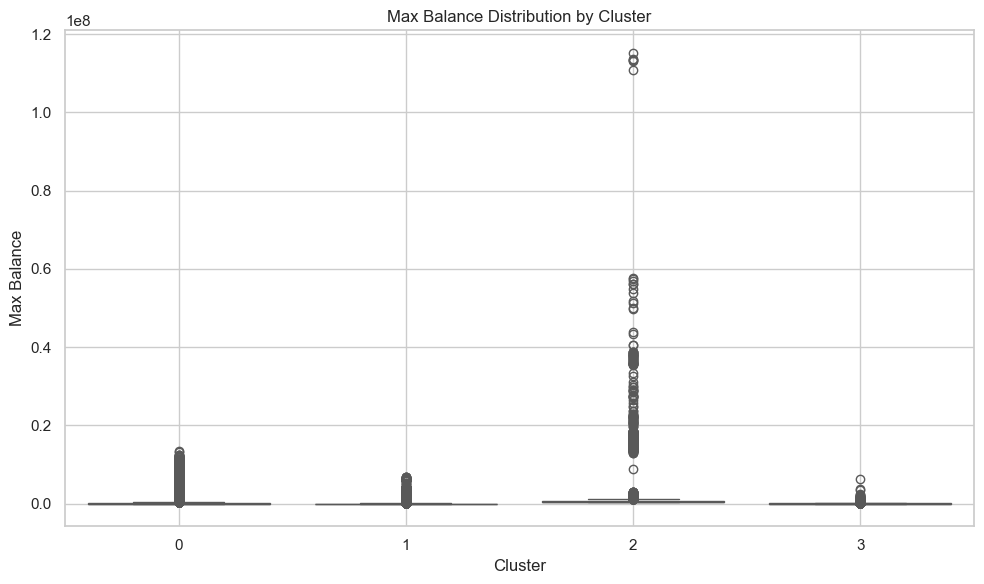

In [962]:
# Visualize cluster profiles
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x='Cluster', y='MAX_BALANCE', hue='Cluster', palette='Set2', legend=False)

plt.title('Max Balance Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Max Balance')
plt.grid(True)
plt.tight_layout()
plt.show()


**Observation**
 Max Balance Distribution by Cluster

Cluster 2 has the highest concentration of very large balances, with numerous extreme outliers exceeding 10 million. This suggests Cluster 2 captures high-net-worth customers.

Clusters 0, 1, and 3 have much lower maximum balances, with relatively tight distributions and only occasional outliers.

The overall spread in Cluster 2 is dramatically larger than in other clusters, confirming segmentation by wealth.

Clusters 0 and 1 look similar in median balance but differ slightly in spread.

Cluster 3 shows modest balances, falling between low-balance clusters and the wealthy segment.

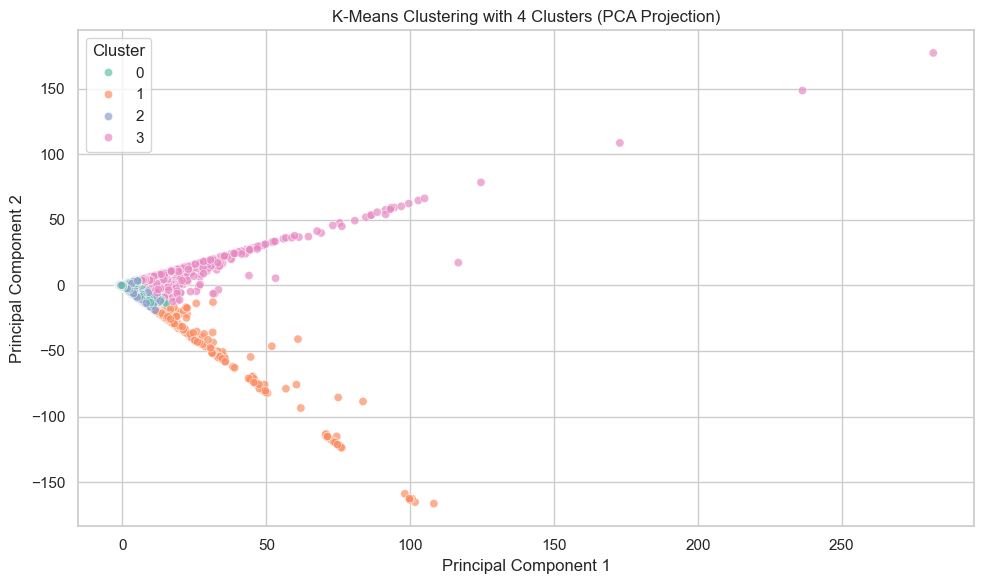

In [964]:
# 1️ Fit KMeans model (4 clusters)
kmeans_model = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans_model.fit_predict(X_scaled)
 
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)


df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["Cluster"] = kmeans_labels

#scatterplot
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_pca,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="Set2",
    alpha=0.7
)
plt.title("K-Means Clustering with 4 Clusters (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


**Observation**:

The four clusters are visibly separated, although there is some overlap near the origin.

Cluster 3 (light pink) contains the most dispersed points, including outliers with very large principal component values, suggesting this cluster contains high-variance or extreme cases (likely high-balance or atypical customers).

Cluster 1 (orange) spreads downward along PC2, indicating it captures a distinct subgroup different from the compact Cluster 0.

Clusters 0 and 2 (light green and blue) are more tightly grouped, likely representing the bulk of customers with more typical, similar behaviors.



# Strategic Summary

Based on the K-Means segmentation with 4 clusters, the following strategies are recommended to tailor products, marketing, and risk management for each segment:

**Cluster 0 — Mainstream Low-Balance Customers**

Focus on onboarding and reactivation initiatives. Recommend micro-savings accounts, simple banking products, and educational content on building financial security. This segment shows high risk due to low balances and limited engagement.

**Cluster 1 — Mature Mid-Balance Customers**

Prioritize engagement and cross-selling strategies. Offer retirement planning support, insurance products, and loyalty programs to encourage retention. Risk is low to moderate, with steady balances.

**Cluster 2 — High-Balance, High-Variance Customers**

Emphasize premium retention and proactive monitoring. Provide dedicated relationship management, wealth advisory services, and exclusive investment opportunities. This group is low risk but requires close oversight due to large balance fluctuations.

**Cluster 3 — Mid-Balance but Volatile Customers**

Drive growth and stabilization with targeted financial planning and risk-adjusted credit offers. Recommend flexible credit products, transaction monitoring tools, and incentives for consistent balances. Risk is moderate, with potential for significant value capture.

